In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from tqdm.notebook import tqdm
import os
import random
from sklearn.model_selection import train_test_split

In [38]:
def load_image_paths(root_dir):
    original_dir = os.path.join(root_dir, "original")
    degraded_dir = os.path.join(root_dir, "degraded")
    
    original_images = [os.path.join(original_dir, img) for img in os.listdir(original_dir)]
    degraded_images = [os.path.join(degraded_dir, img) for img in os.listdir(degraded_dir)]
    print(degraded_images[:5])
    # Mapping original to degraded
    mapping = {}
    for orig_path in original_images:
        base_name = os.path.basename(orig_path)
        # print(base_name)
        idx, barcode, _ = base_name.split('_')
        # print([img for img in degraded_images])
        degraded_versions = [img for img in degraded_images if img.startswith(f"./data/tmp/degraded/{idx}_{barcode}")]
        mapping[orig_path] = degraded_versions
    
    return mapping

# Assuming '/data/tmp' is your root directory
root_dir = './data/tmp'
image_paths = load_image_paths(root_dir)

# Splitting into train and test sets
original_images = list(image_paths.keys())
train_orig, test_orig = train_test_split(original_images, test_size=0.2, random_state=42)

# Creating train and test mappings
train_mapping = {orig: image_paths[orig] for orig in train_orig}
test_mapping = {orig: image_paths[orig] for orig in test_orig}

['./data/tmp/degraded/65_6482759342299_ean13_8.png', './data/tmp/degraded/9_1361718788093_ean13_3.png', './data/tmp/degraded/61_1698694150706_ean13_9.png', './data/tmp/degraded/11_3543421134192_ean13_9.png', './data/tmp/degraded/99_2198838237274_ean13_9.png']


In [39]:
class ImageDataset(Dataset):
    def __init__(self, mapping, transform=None):
        self.mapping = mapping
        self.transform = transform
        self.original_images = list(mapping.keys())
    
    def __len__(self):
        return len(self.original_images)
    
    def __getitem__(self, idx):
        orig_path = self.original_images[idx]
        degraded_paths = self.mapping[orig_path]
        
        # Example: loading the first degraded image
        degraded_path = random.choice(degraded_paths) # Randomly select one for variability
        orig_image = Image.open(orig_path).convert('L')
        degraded_image = Image.open(degraded_path).convert('L')
        
        if self.transform:
            orig_image = self.transform(orig_image)
            degraded_image = self.transform(degraded_image)
        
        return degraded_image, orig_image

In [40]:
# Define a function to convert images to binary
def to_binary(tensor, threshold=0.5):
    # Convert to grayscale by averaging the channels
    grayscale = tensor.mean(dim=0, keepdim=True)
    # Apply threshold
    binary = (grayscale > threshold).float()
    return binary

# Create the transform pipeline
#transform = transforms.Compose([
#    transforms.Resize((256, 512)),
#    transforms.ToTensor(),
#    transforms.Lambda(lambda x: to_binary(x))
#])


transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_mapping, transform=transform)
test_dataset = ImageDataset(test_mapping, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

torch.Size([1, 1, 256, 512])


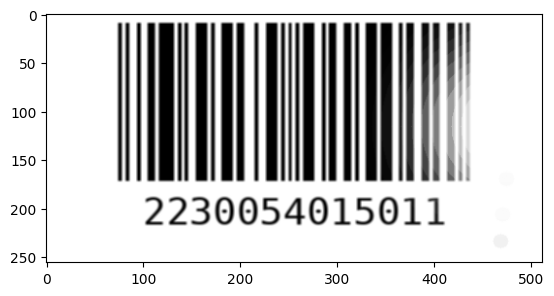

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor to a numpy array
def imshow(img):
    img = img.numpy() # Convert tensor to numpy array
    plt.imshow(np.transpose(img, (1, 2, 0))) # Convert from CxHxW to HxWxC
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next() to get the next batch

# Show images for the first image in the batch
print(images[0].unsqueeze(0).shape)
imshow(torchvision.utils.make_grid(images[0].unsqueeze(0)))

In [42]:
from model import Autoencoder

In [43]:
model = Autoencoder()

In [44]:
for data in train_loader:
    print(data[0].shape)
    print(data[0][0].shape)
    break

torch.Size([16, 1, 256, 512])
torch.Size([1, 256, 512])


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

num_epochs = 50

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/3), gamma=0.1)

# Train the model
for epoch in range(num_epochs):
    
    model.train()  # Set model to training mode
    total_loss = 0
    num_batches = 0
    
    loop = tqdm(train_loader, leave=True)
    for degraded_images, original_images in loop:
        degraded_images = degraded_images.to(device)
        original_images = original_images.to(device)
        
        reconstructed_images = model(degraded_images)
        loss = criterion(reconstructed_images, original_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())
    
    average_loss = total_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}")
    scheduler.step()

    # Evaluate every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Inference mode, gradients not calculated
            val_loss = 0
            val_batches = 0
            for degraded_images, original_images in test_loader:
                degraded_images = degraded_images.to(device)
                original_images = original_images.to(device)
                
                reconstructed_images = model(degraded_images)
                loss = criterion(reconstructed_images, original_images)
                
                val_loss += loss.item()
                val_batches += 1
            
            average_val_loss = val_loss / val_batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {average_val_loss:.4f}")


# Save the model
torch.save(model.state_dict(), 'model.pth')

cpu


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/50], Average Loss: 0.2259


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/50], Average Loss: 0.2192


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/50], Average Loss: 0.2099


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/50], Average Loss: 0.1958


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/50], Average Loss: 0.1766


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/50], Average Loss: 0.1567


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/50], Average Loss: 0.1387


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/50], Average Loss: 0.1227


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/50], Average Loss: 0.1084


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/50], Average Loss: 0.0939
Epoch [10/50], Validation Loss: 0.0801


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/50], Average Loss: 0.0880


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/50], Average Loss: 0.0779


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/50], Average Loss: 0.0673


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/50], Average Loss: 0.0603


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/50], Average Loss: 0.0573


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/50], Average Loss: 0.0519


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/50], Average Loss: 0.0502


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/50], Average Loss: 0.0515


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/50], Average Loss: 0.0476


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/50], Average Loss: 0.0461
Epoch [20/50], Validation Loss: 0.0432


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/50], Average Loss: 0.0509


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/50], Average Loss: 0.0468


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/50], Average Loss: 0.0469


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/50], Average Loss: 0.0500


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/50], Average Loss: 0.0516


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26/50], Average Loss: 0.0473


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27/50], Average Loss: 0.0483


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28/50], Average Loss: 0.0501


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [29/50], Average Loss: 0.0438


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [30/50], Average Loss: 0.0480
Epoch [30/50], Validation Loss: 0.0348


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [31/50], Average Loss: 0.0469


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [32/50], Average Loss: 0.0467


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [33/50], Average Loss: 0.0466


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [34/50], Average Loss: 0.0441


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [35/50], Average Loss: 0.0458


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [36/50], Average Loss: 0.0434


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [37/50], Average Loss: 0.0450


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [38/50], Average Loss: 0.0471


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [39/50], Average Loss: 0.0450


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [40/50], Average Loss: 0.0450
Epoch [40/50], Validation Loss: 0.0389


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [41/50], Average Loss: 0.0459


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [42/50], Average Loss: 0.0445


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [43/50], Average Loss: 0.0450


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [44/50], Average Loss: 0.0486


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [45/50], Average Loss: 0.0475


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [46/50], Average Loss: 0.0473


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [47/50], Average Loss: 0.0484


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [48/50], Average Loss: 0.0476


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [49/50], Average Loss: 0.0455


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [50/50], Average Loss: 0.0473
Epoch [50/50], Validation Loss: 0.0409
